In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans, DBSCAN

## Prepare data and labels 

In [2]:
dataset = 'antisaccade'
#dataset = 'processing_speed'

In [3]:
if dataset == 'antisaccade':
    data = np.load('./data/LR_task_with_antisaccade_synchronised_min_hilbert.npz')
    data_y = np.load('./data/LR_task_with_antisaccade_synchronised_min_hilbert_clustering.npz')
elif dataset == 'processing_speed':
    data = np.load('./data/Direction_task_with_processing_speed_synchronised_min_hilbert.npz')
    data_y = np.load('./data/Direction_task_with_processing_speed_synchronised_min_hilbert_clustering.npz')
X = data['EEG']
y = data_y['labels']

In [4]:
# Run this when using the features extracted by a CNN on age regression task 
#X = np.load("features_antisaccade_age.npy")

In [5]:
num_samples, dummy_dim, features = X.shape
X.shape

(30842, 1, 258)

In [6]:
X = X.reshape((num_samples, dummy_dim*features))

In [7]:
X.shape

(30842, 258)

In [8]:
y.shape

(30842, 3)

In [9]:
labels = y[:,1]
labels

array(['0', '1', '1', ..., '1', '0', '0'], dtype='<U21')

In [10]:
INDEX = 'all'
#indices = np.where(labels==INDEX)
#indices

In [11]:
#X = X[indices]
#len(X)

In [12]:
names = y.T[2 if dataset=='antisaccade' else 3]
#names = names[indices]
names

array(['AA0', 'AA0', 'AA0', ..., 'BZ9', 'BZ9', 'BZ9'], dtype='<U21')

## Perform clustering 

In [33]:
NUM_CLUSTERS = 3

In [34]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X)
cluster_labels = kmeans.labels_ 

#clustering = DBSCAN(eps=1e4, min_samples=2).fit(X)
#cluster_labels = clustering.labels_

cluster_labels

array([2, 2, 2, ..., 0, 0, 2], dtype=int32)

## Compute avg age in the clusters 

In [35]:
df = pd.read_excel('participants_concat.xlsx')

In [36]:
from tqdm import tqdm 

clusters = [[] for i in range(NUM_CLUSTERS)]

skipped = 0

# Add up the ages of the participants in the samples 
for i in tqdm(range(len(cluster_labels))):
    if len(np.array(df.loc[df['Subject'] == names[i]]['Age'])) > 0 and cluster_labels[i] != -1:
        clusters[cluster_labels[i]].append(np.array(df.loc[df['Subject'] == names[i]]['Age'])[0])  
    else: 
        skipped += 1

skipped

100%|██████████| 30842/30842 [00:46<00:00, 656.87it/s]


286

In [37]:
for i, cluster in enumerate(clusters):
    print(f"cluster {i} has {len(cluster)} elements")

cluster 0 has 5856 elements
cluster 1 has 2 elements
cluster 2 has 24698 elements


In [38]:
# Compute average age in each cluster 
mean_cluster = [-1 for i in range(NUM_CLUSTERS)]
std_cluster = [-1 for i in range(NUM_CLUSTERS)]

for i, cluster in enumerate(clusters):
    if len(cluster) > 0:
        mean_cluster[i] = np.mean(cluster)
        std_cluster[i] = np.std(cluster)
    else:
        mean_cluster[i] = 0
        std_cluster[i] = 0

for i in range(len(mean_cluster)):
    print(f"Cluster {i}: mean: {mean_cluster[i]}, std: {std_cluster[i]}")

Cluster 0: mean: 14507.685280054644, std: 8155.387856565304
Cluster 1: mean: 7335.0, std: 0.0
Cluster 2: mean: 18244.5172888493, std: 8008.468232998567


## Plot the clusters 

8155.387856565304
8008.468232998567


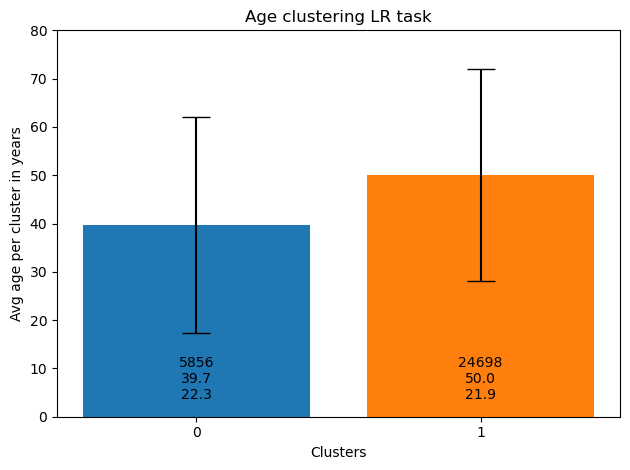

In [39]:
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

OUTLIER_THRESH = 50 

bars = []
outliers = 0
indices = []
cnt = 0
for i, cluster in enumerate(clusters):
    if len(cluster) > OUTLIER_THRESH:
        print(std_cluster[i])
        indices.append(i)
        bars.append(plt.bar(cnt, mean_cluster[i]/365, yerr=std_cluster[i]/365.0, capsize=10))
        cnt += 1
    else:
        outliers +=1

plt.xticks(np.arange(start=0, stop=NUM_CLUSTERS-outliers, step=1))
plt.xlabel("Clusters")
plt.ylabel("Avg age per cluster in years")
axes = plt.gca()
axes.set_ylim([0,80])
plt.title(f"Age clustering LR task")
plt.tight_layout()

for i, bar in enumerate(bars):
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, 3, f'{len(clusters[indices[i]])}' + '\n{0:.1f}'.format(mean_cluster[indices[i]] / 365.0) + '\n{0:.1f}'.format(std_cluster[indices[i]] / 365.0), ha='center', va='bottom')

plt.savefig(f"./images/clustering/age_clustering_hilbert_feature_extraction_numclusters_{NUM_CLUSTERS}_{dataset}.png")
#plt.savefig(f"./images/clustering/age_clustering_antisaccade_hilbert_numclusters_{NUM_CLUSTERS}_{dataset}.png")
plt.show()

In [40]:
unique_0 = np.unique(clusters[0])
len(unique_0)

255

In [41]:
unique_1 = np.unique(clusters[1])
len(unique_1)

1

In [42]:
x = unique_0
y = np.zeros_like(x)

In [43]:
x = np.concatenate((x, unique_1))

In [44]:
y = np.concatenate((y, np.ones_like(unique_1)))

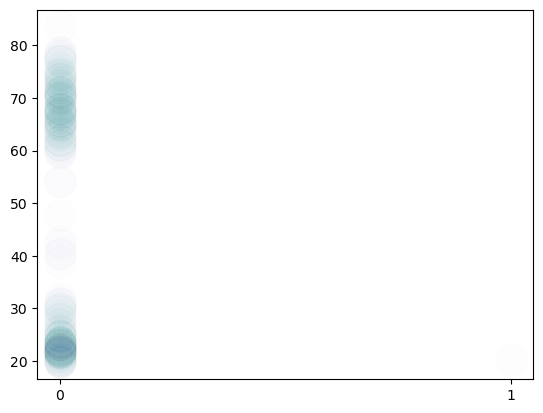

In [45]:
plt.scatter(y, x/365.0, alpha=0.008, s=500)
plt.xticks(np.arange(start=0, stop=1.1, step=1))

plt.savefig(f"./images/clustering/age_clustering_scatter_hilbert_feature_extraction_numclusters_{NUM_CLUSTERS}_{dataset}.png")

plt.show()


In [46]:
old = np.array(clusters[0])
young = np.array(clusters[1])

In [47]:
correct_old = len(np.where(old > 35*365)[0])
correct_old

2157

In [48]:
accuracy_old = correct_old / len(old)
accuracy_old

0.36834016393442626

In [49]:
correct_young = len(np.where(young <= 35*365)[0])
correct_young

2

In [50]:
acc_young = correct_young / len(young)
acc_young

1.0

In [51]:
correct = len(np.where(old > 35*365)[0]) + len(np.where(young <= 35*365)[0])
correct

2159

In [52]:
accuracy = correct / (len(old) + len(young))
accuracy

0.3685558210993513